# Data-Driven Analysis and Forecasting of Child Mortality Rates

## Import libraries
We use Python libraries for data analysis, modeling, and interpretation. Pandas and NumPy handle data preparation and cleaning, while Matplotlib and Seaborn are used for visualizations. Scikit-learn provides tools for preprocessing, training a Random Forest model, hyperparameter tuning, and evaluating performance. SHAP is used for model explainability to understand feature importance and prediction drivers. Pathlib and Joblib manage file handling and saving trained models.

In [1]:
from pathlib import Path
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

import shap

## Configuration
In this section, we define the core settings for the project. The script searches for the cleaned dataset (ahpf_outcomes_clean.csv) in multiple possible locations and raises an error if it is not found. An output directory is created to store trained models and generated results. The target variable is set to Infant and young child mortality rate, and lag features of 1 and 2 years are specified to capture temporal patterns. A fixed random state ensures reproducibility, and all available CPU cores are used (n_jobs=-1) to speed up model training.

In [2]:
CANDIDATES = [
    Path("ahpf_outcomes_clean.csv"),
    Path("data/anjana/processed/ahpf_outcomes_clean.csv"),
    Path.cwd() / "ahpf_outcomes_clean.csv",
]
AHPF_FILE = next((p for p in CANDIDATES if p.exists()), None)
if AHPF_FILE is None:
    raise FileNotFoundError("Couldn’t find 'ahpf_outcomes_clean.csv'.")

OUT_DIR = Path("outputs/models")
OUT_DIR.mkdir(parents=True, exist_ok=True)

TARGET = "Infant and young child mortality rate"
LAGS = [1, 2]
RANDOM_STATE = 42
N_JOBS = -1

print("Using file:", AHPF_FILE)
print("Output dir:", OUT_DIR.resolve())


Using file: data\anjana\processed\ahpf_outcomes_clean.csv
Output dir: C:\Users\ANJANA MANOJ\Desktop\Capstone A\outputs\models


## Utility Functions

This section defines helper functions used throughout the workflow:

load_and_clean(path): Reads the dataset, standardizes column formats, fixes the year values, cleans numeric entries, removes missing values, and filters to keep only mortality rates (DecimalOne).

make_panel(df): Converts the cleaned dataset into a panel (state–year wide format), where each indicator becomes a column.

add_lags(panel, cols, lag_years): Creates lagged versions of selected columns (e.g., 1-year and 2-year lags for the target) to capture temporal dependencies.

temporal_train_test_split(panel_with_lags, n_test_years): Splits the dataset into training and testing sets based on years, ensuring proper time ordering.

report(name, y_true, y_pred): Evaluates model predictions using R² and Mean Absolute Error (MAE), printing results in a simple format.

Together, these functions streamline data preparation, feature engineering, splitting, and evaluation, so the modeling process remains clean and reproducible.

In [19]:
def load_and_clean(path):
    df = pd.read_csv(path, low_memory=False)
    df["Name"]  = df["Name"].astype(str).str.strip()
    df["State"] = df["State"].astype(str).str.strip()

    if "Period" in df.columns:
        df["Year"] = pd.to_numeric(df["Period"], errors="coerce")
    elif "Year" in df.columns:
        df["Year"] = pd.to_numeric(df["Year"], errors="coerce")

    df["Value"] = pd.to_numeric(
        df["Value"].astype(str)
            .str.replace(",", "", regex=False)
            .str.replace("\u2212", "-", regex=False),
        errors="coerce"
    )
    df = df.dropna(subset=["State", "Year", "Name", "Value"])
    df = df[df["UnitType"] == "DecimalOne"]
    return df

def make_panel(df):
    wide = df.pivot_table(
        index=["State", "Year"], 
        columns="Name", 
        values="Value", 
        aggfunc="mean"
    ).sort_index()
    if TARGET not in wide.columns:
        raise ValueError(f"Target '{TARGET}' not found. Columns: {list(wide.columns[:10])}")
    return wide

def add_lags(panel, cols, lag_years):
    out = panel.copy()
    for col in cols:
        for k in lag_years:
            out[f"{col}_lag{k}"] = out.groupby(level=0)[col].shift(k)
    return out

def temporal_train_test_split(panel_with_lags, n_test_years=2):
    years = panel_with_lags.index.get_level_values("Year").unique().sort_values()
    test_years = years[-n_test_years:]
    train_years = years[:-n_test_years]
    need_cols = [TARGET] + [f"{TARGET}_lag{k}" for k in LAGS]
    train = panel_with_lags.loc[(slice(None), train_years), :].dropna(subset=need_cols)
    test  = panel_with_lags.loc[(slice(None), test_years),  :].dropna(subset=need_cols)
    return train, test, train_years, test_years

def report(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name}: R² = {r2:.3f} | MAE = {mae:.3f}")
    return r2, mae

## Load & Clean Data + Exploratory Analysis
In this step, the dataset is loaded using the load_and_clean function. The function standardizes column names, converts year values into numeric format, cleans the target values, and filters the data to keep only valid mortality rates (DecimalOne). After loading, we check the total number of rows, confirm the unit type, and preview a few records to ensure the data looks correct.

We also generate summary statistics for the target variable (Infant and young child mortality rate) to understand its overall distribution, including minimum, maximum, median, and spread. Finally, a histogram with a density curve is plotted to visualize how mortality rates are distributed across states and years. This gives an early indication of skewness, the presence of outliers, and the overall scale of the values before building models.

Rows after load: 9,681
UnitTypes: ['DecimalOne']
Preview:
      Code                                   Name Period  \
0   3.4.1  Infant and young child mortality rate   2008   
1   3.4.1  Infant and young child mortality rate   2008   
2   3.4.1  Infant and young child mortality rate   2008   
9   3.4.1  Infant and young child mortality rate   2008   
10  3.4.1  Infant and young child mortality rate   2008   

              GeographicAreaName  Value    UnitType State    Year  
0   Australian Capital Territory    6.5  DecimalOne   ACT  2008.0  
1   Australian Capital Territory    3.4  DecimalOne   ACT  2008.0  
2   Australian Capital Territory    5.0  DecimalOne   ACT  2008.0  
9   Australian Capital Territory  148.0  DecimalOne   ACT  2008.0  
10  Australian Capital Territory  110.6  DecimalOne   ACT  2008.0  

Target value stats:
 count    1344.000000
mean       47.399182
std        50.686138
min         0.000000
25%         3.475000
50%        10.300000
75%        82.100000
max      

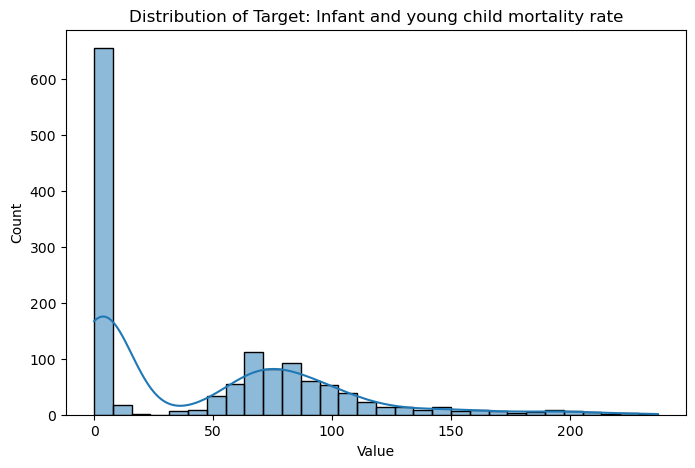

In [20]:
df = load_and_clean(AHPF_FILE)
print(f"Rows after load: {len(df):,}")
print("UnitTypes:", df["UnitType"].unique())
print("Preview:\n", df.head())

# Target value stats
print("\nTarget value stats:\n", 
      df[df["Name"]==TARGET]["Value"].describe())

# Histogram of target
plt.figure(figsize=(8,5))
sns.histplot(df[df["Name"]==TARGET]["Value"], bins=30, kde=True)
plt.title(f"Distribution of Target: {TARGET}")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()


The distribution of infant and young child mortality rates is highly right-skewed, with the majority of observations clustered at very low values, particularly between 0 and 5. This indicates that in many states and years, mortality outcomes have already reached relatively low levels, reflecting broad improvements in child health. However, the presence of a secondary peak around 50–100 and a long tail extending beyond 200 highlights that certain regions or periods still experienced significantly higher mortality. This contrast suggests persistent regional disparities, where some states consistently perform well while others face ongoing health challenges. From a modeling perspective, the skewed nature of the data means predictions will often be biased toward lower values, while extreme high cases (outliers) remain important to capture as they carry substantial policy and health implications.

## Boxplot of Mortality Rate by State
This plot shows the distribution of Infant and young child mortality rates across different states. Each box represents the spread of values for a state, with the line inside marking the median. The length of the box indicates the interquartile range (IQR), while the whiskers and points highlight variability and potential outliers.

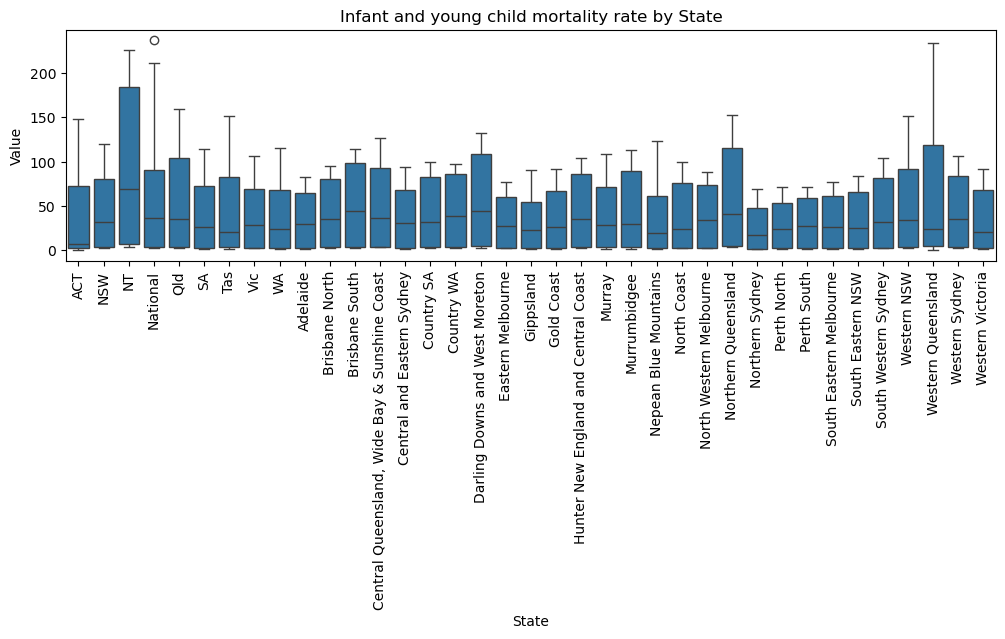

In [23]:
plt.figure(figsize=(12,3))
sns.boxplot(x="State", y="Value", data=df[df["Name"]==TARGET])
plt.title(f"{TARGET} by State")
plt.xticks(rotation=90)
plt.show()


The boxplot of infant and young child mortality rates by state highlights both central tendencies and variability across regions. While many states cluster around moderate values, there is considerable variation in their spreads, with some showing narrow distributions and others displaying wide ranges that suggest fluctuating outcomes over time. States such as NT and WA exhibit higher median values and greater variability, pointing to persistent health challenges. By contrast, states like ACT and SA generally report lower medians, although ACT shows an outlier at an unusually high level. Overall, the figure indicates clear regional disparities: some states consistently achieve lower mortality rates, while others experience greater volatility and occasional extreme values, underscoring the uneven distribution of health outcomes across the country.

## Correlation Heatmap of Indicators

This heatmap shows the pairwise correlations between all available health indicators across years. By pivoting the dataset into a year–indicator format, we can examine how strongly different measures move together over time. The color scale highlights both positive and negative relationships: warmer tones indicate strong positive correlations, while cooler tones represent negative or weaker relationships. Including annotations provides exact correlation coefficients for easier interpretation. This analysis is useful for identifying redundancy between indicators (highly correlated variables) and for highlighting potential drivers of infant and young child mortality rates that may be important for modeling and policy insights.

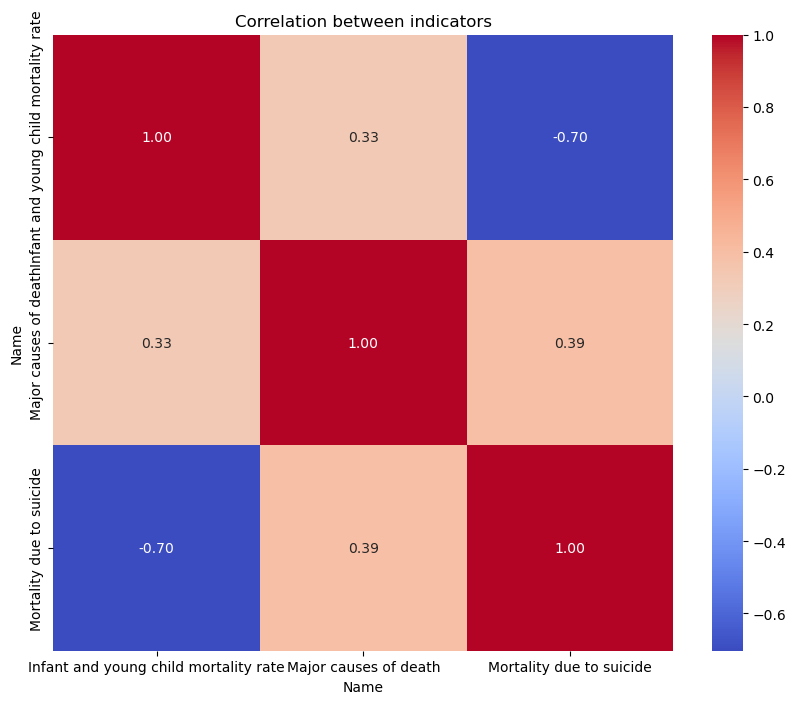

In [15]:
indicator_cols = df["Name"].unique().tolist()
corr_df = df.pivot_table(index="Year", columns="Name", values="Value")

plt.figure(figsize=(10,8))
sns.heatmap(corr_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation between indicators")
plt.show()


The correlation analysis shows that infant and young child mortality has only a modest positive relationship with overall mortality from major causes (r = 0.33), suggesting that while broader health system or socioeconomic conditions affect both, they are not perfectly aligned. Interestingly, there is a strong negative correlation with mortality due to suicide (r = −0.70). This should not be interpreted as a direct causal link; rather, it likely reflects demographic and regional differences. For example, areas with higher infant mortality often differ in population structure, health resources, and risk factors compared to those with higher suicide mortality, which typically affects older age groups. Overall, the heatmap highlights that while infant mortality partially tracks general mortality, it is shaped by distinct drivers that may not overlap with other causes of death.

## Trends in Infant and Young Child Mortality Over Time by State
This line plot illustrates how infant and young child mortality rates have changed from year to year across different states. Each line represents the average mortality rate for a state, allowing for a comparison of both overall trends and regional differences. The visualization highlights whether mortality is generally declining over time, a common expectation given improvements in healthcare and child health programs, or whether some states show persistent or fluctuating patterns. By placing the legend outside the chart, the plot remains readable despite the large number of states included. Overall, this plot provides a temporal perspective, showing how mortality rates evolve over time and where disparities between states persist or narrow.

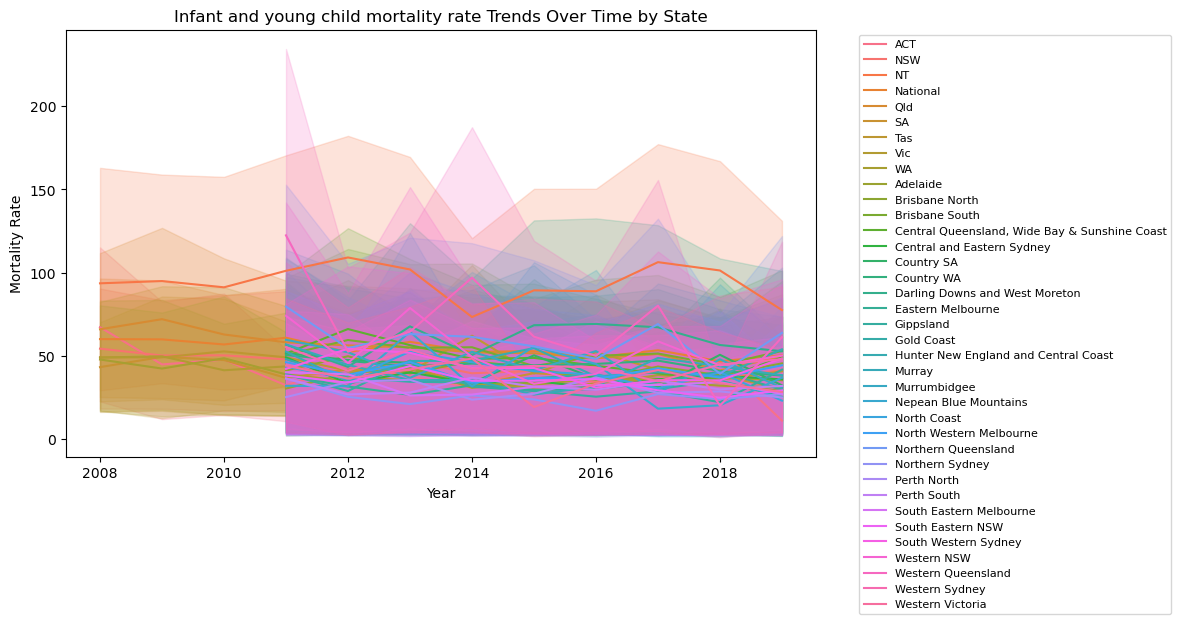

In [18]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df[df["Name"]==TARGET], x="Year", y="Value", hue="State", estimator="mean")
plt.title(f"{TARGET} Trends Over Time by State")
plt.ylabel("Mortality Rate")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()


The trend plot indicates that while most states maintain relatively low infant and young child mortality rates over time, there are noticeable disparities across regions. A majority of states cluster near the lower end of the scale, suggesting overall improvements in child health outcomes. However, certain states such as NT and WA consistently show higher mortality rates and greater variability across years, reflecting persistent challenges. In contrast, states like ACT and SA remain at the lower range with more stable outcomes. The overall pattern suggests that national progress in reducing child mortality is uneven, with some states benefiting more than others, highlighting the importance of targeted interventions in high-mortality regions.

## Panel Creation, Lag Features, and Temporal Train/Test Split
This section restructures the dataset into a panel format and prepares it for modeling. First, the data is pivoted so that each row represents a state–year pair, with columns for different health indicators. Lag features of the target variable (infant and young child mortality rate) are then created, allowing the model to learn from past values (for example, the previous year’s mortality rate) when predicting current outcomes. Next, the dataset is split chronologically, with earlier years used for training and the last two years reserved for testing, ensuring no future information leaks into the training process. Finally, the feature set is defined by combining other health indicators with these lagged mortality rates, and the data is separated into training (X_train, y_train) and testing (X_test, y_test) sets. This setup ensures the model captures both cross-sectional (across states) and temporal (over time) patterns in mortality trends.

In [22]:
wide = make_panel(df)
wide_lag = add_lags(wide, [TARGET], LAGS)
print(f"Panel shape: {wide_lag.shape}")
print("Columns:", list(wide_lag.columns))
train_panel, test_panel, train_years, test_years = temporal_train_test_split(wide_lag, n_test_years=2)
print("Train years:", train_years)
print("Test years :", test_years)
print("Train shape:", train_panel.shape, "Test shape:", test_panel.shape)
feat_now = [c for c in wide.columns if c != TARGET]
feat_lag = [c for c in wide_lag.columns if c.startswith(f"{TARGET}_lag")]
FEATURE_COLS = feat_now + feat_lag

X_train = train_panel[FEATURE_COLS].copy()
y_train = train_panel[TARGET].copy()
X_test  = test_panel[FEATURE_COLS].copy()
y_test  = test_panel[TARGET].copy()


Panel shape: (360, 5)
Columns: ['Infant and young child mortality rate', 'Major causes of death', 'Mortality due to suicide', 'Infant and young child mortality rate_lag1', 'Infant and young child mortality rate_lag2']
Train years: Index([2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0,
       2017.0],
      dtype='float64', name='Year')
Test years : Index([2018.0, 2019.0], dtype='float64', name='Year')
Train shape: (212, 5) Test shape: (74, 5)


## Training the Random Forest Model
In this step, a Random Forest model is trained to predict infant and young child mortality rates. The model is wrapped in a pipeline that first imputes missing values using the mean and then fits the Random Forest regressor. A randomized search over hyperparameters is performed, including the number of trees, maximum depth, minimum samples required for splits and leaves, and the number of features considered at each split. To respect the time-series nature of the data, cross-validation is carried out using TimeSeriesSplit, which ensures training only uses past years to predict future ones. The best-performing model is then selected based on R² scores, and its accuracy is evaluated on the test set using R² and mean absolute error (MAE). Finally, the trained pipeline is saved for reuse, ensuring reproducibility and efficiency in later steps.

In [6]:
rf_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("rf", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS))
])

param_dist = {
    "rf__n_estimators": [200, 400, 600],
    "rf__max_depth": [None, 6, 10, 20],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4],
    "rf__max_features": ["auto", "sqrt", 0.5]
}

tscv = TimeSeriesSplit(n_splits=min(len(train_years)-1, 5))
rnd_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring="r2",
    n_jobs=N_JOBS,
    cv=tscv,
    random_state=RANDOM_STATE,
    verbose=1,
    return_train_score=True
)

rnd_search.fit(X_train, y_train)
best_rf = rnd_search.best_estimator_
print("\nBest RF params:", rnd_search.best_params_)

pred_rf = best_rf.predict(X_test)
r2_rf, mae_rf = report("RandomForest", y_test, pred_rf)

# Save model
joblib.dump(best_rf, OUT_DIR / "best_rf_pipeline.joblib")
print("Saved Random Forest model.")


Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best RF params: {'rf__n_estimators': 200, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_features': 'sqrt', 'rf__max_depth': 6}
RandomForest: R² = 0.473 | MAE = 6.668
Saved Random Forest model.


The training output shows that the Random Forest model was tuned using 20 different hyperparameter combinations with 5-fold time-series cross-validation, resulting in 100 separate fits. The best-performing configuration used 200 trees with a maximum depth of 6, square-root feature selection at each split, and relatively flexible split rules, which helped balance predictive power with overfitting control. When evaluated on the test years (2018–2019), the model achieved an R² of 0.473, meaning it explained about 47% of the variation in infant and young child mortality rates, and a mean absolute error (MAE) of 6.7, indicating predictions were off by roughly seven units on average. While this reflects a moderate level of accuracy, it also highlights that there are factors influencing mortality rates that the model does not fully capture. The final tuned model was saved for reuse, ensuring reproducibility and efficiency in later analysis.

## Feature Importance and Model Explainability
This section explores which variables most strongly influence the Random Forest’s predictions. First, permutation importance is calculated by repeatedly shuffling each feature and measuring the drop in model accuracy, which highlights how much the model relies on that feature. The results are summarized in a ranked table and a bar chart, showing the top 20 predictors. In addition, SHAP (SHapley Additive exPlanations) values are computed to provide a deeper interpretation of feature contributions. SHAP quantifies how each feature pushes predictions higher or lower for individual cases, making the model’s decision process more transparent. Together, permutation importance and SHAP provide complementary insights, permutation gives a global ranking of features, while SHAP shows both global and local effects, allowing us to identify which health indicators and lagged mortality values are the main drivers of predicted outcomes.


Computing permutation importance...

Top 10 features by permutation importance:
                                       feature  importance
3  Infant and young child mortality rate_lag2    0.342551
2  Infant and young child mortality rate_lag1    0.085327
0                       Major causes of death    0.055790
1                    Mortality due to suicide   -0.015960


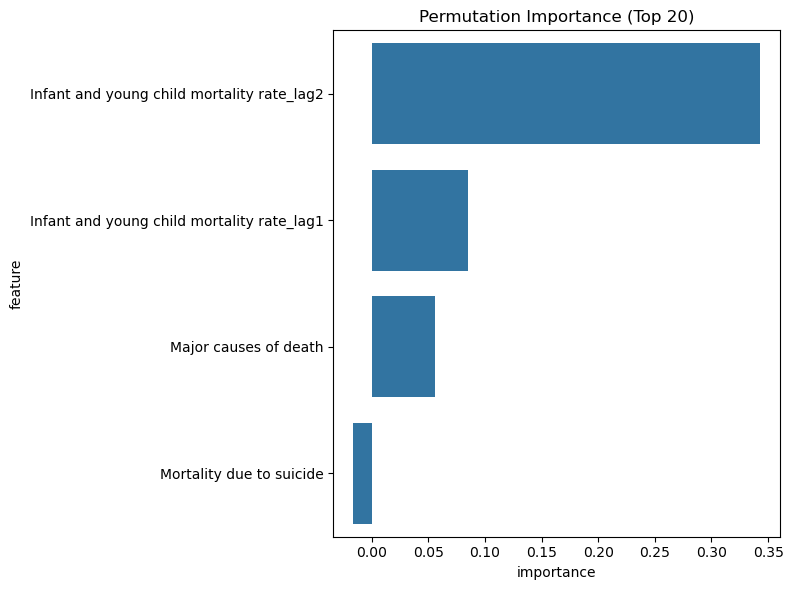


Computing SHAP values...


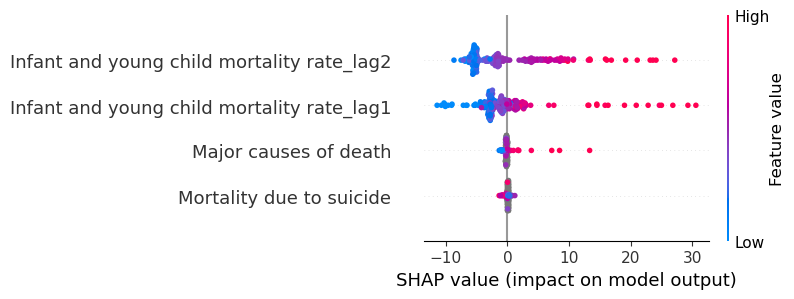

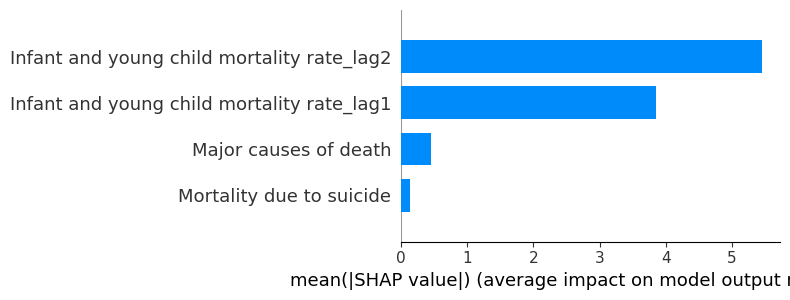

In [7]:
perm = permutation_importance(best_rf, X_test, y_test, n_repeats=30,
                              random_state=RANDOM_STATE, n_jobs=N_JOBS)
imp = pd.DataFrame({"feature": X_train.columns, 
                    "importance": perm.importances_mean}).sort_values("importance", ascending=False)
print("\nTop 10 features by permutation importance:\n", imp.head(10))

plt.figure(figsize=(8,6))
sns.barplot(data=imp.head(20), y="feature", x="importance")
plt.title("Permutation Importance (Top 20)")
plt.tight_layout()
plt.show()

# SHAP
print("\nComputing SHAP values...")
rf_model = best_rf.named_steps["rf"]
X_sample = shap.utils.sample(X_train, 200, random_state=RANDOM_STATE)
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer(X_sample)

shap.summary_plot(shap_values.values, X_sample, show=True)
shap.summary_plot(shap_values.values, X_sample, plot_type="bar", show=True)


The feature importance results show that lagged values of infant and young child mortality are the strongest predictors, with the two-year lag having the highest impact, followed by the one-year lag. This makes sense because past mortality patterns strongly influence current outcomes. Other indicators, such as major causes of death and mortality due to suicide, contribute less, and in the case of suicide, may even introduce noise. Overall, the model is mostly relying on temporal trends, with only minor input from other health factors.

## What-if Scneario Analysis
This section explores how sensitive the model’s predictions are to changes in the most important feature, which in this case is the two-year lag of infant and young child mortality. A set of hypothetical scenarios is created by adjusting this driver up or down by 5% and 10%. For each adjustment, predictions are recalculated, and the difference (delta) from the baseline predictions is measured. The results are then averaged by state and displayed in a bar plot, showing whether increases or decreases in the main driver lead to higher or lower predicted mortality rates. This analysis is valuable because it provides an interpretable “what-if” framework, helping to understand the direction and magnitude of impact that key drivers have on outcomes, and giving policymakers a sense of potential effects if mortality trends shifted slightly.


What-if analysis using main driver: Infant and young child mortality rate_lag2

Scenario summary:
       State Scenario     Delta
0       ACT     +10%  0.102515
1       ACT      +5% -0.105744
2       ACT     -10% -0.321404
3       ACT      -5%  0.112131
4  Adelaide     +10%  0.186828


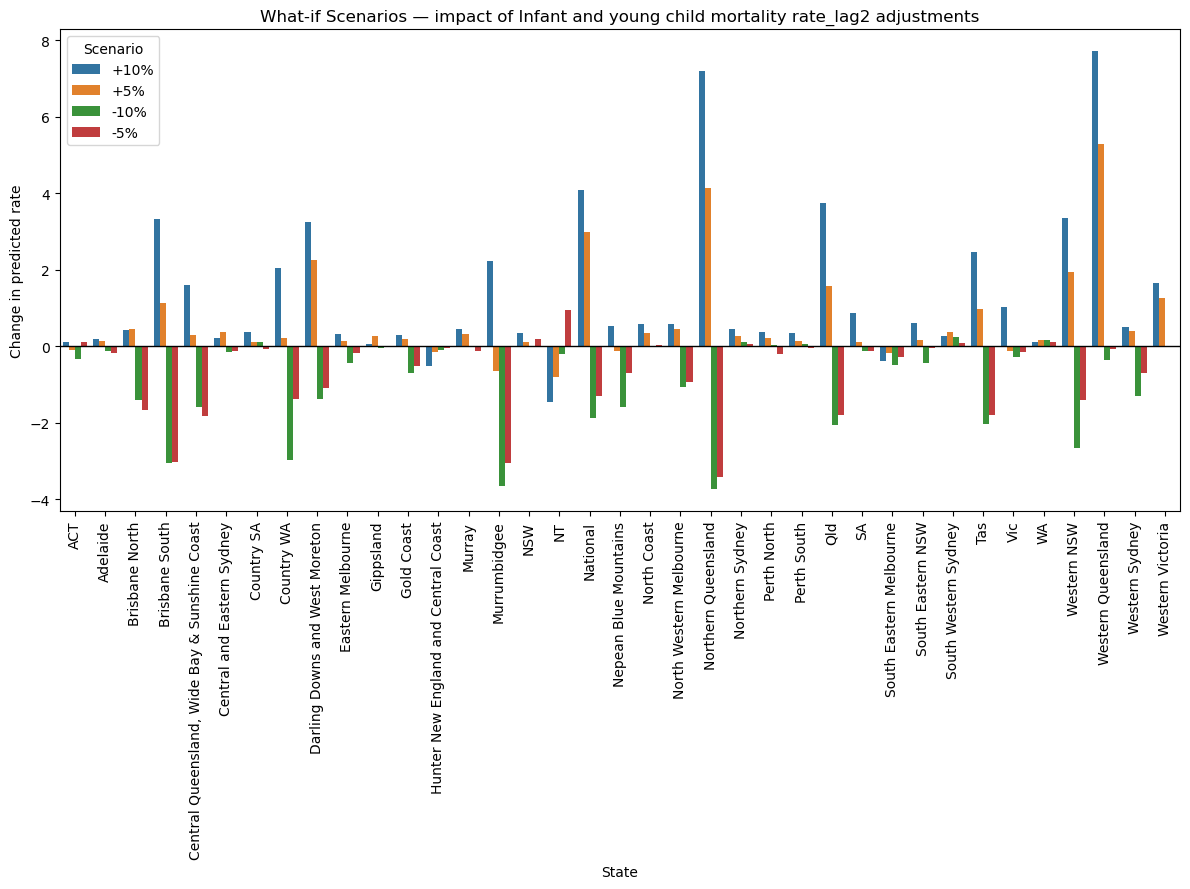

In [11]:
if not imp.empty:
    main_driver = imp.iloc[0]["feature"]
    print(f"\nWhat-if analysis using main driver: {main_driver}")
    scenarios = {"-10%": 0.9, "-5%": 0.95, "+5%": 1.05, "+10%": 1.10}
    scenario_results = []
    for scen, factor in scenarios.items():
        X_sim = X_test.copy()
        X_sim[main_driver] *= factor
        pred_sim = best_rf.predict(X_sim)
        delta = pred_sim - pred_rf
        scenario_results.append(pd.DataFrame({"State": y_test.index.get_level_values(0), "Scenario": scen, "Delta": delta}))
    scenario_df = pd.concat(scenario_results)
    scenario_summary = scenario_df.groupby(["State", "Scenario"])["Delta"].mean().reset_index()
    print("\nScenario summary:\n", scenario_summary.head())

    plt.figure(figsize=(12,9))
    sns.barplot(data=scenario_summary, x="State", y="Delta", hue="Scenario")
    plt.axhline(0, color="k", lw=1)
    plt.title(f"What-if Scenarios — impact of {main_driver} adjustments")
    plt.ylabel("Change in predicted rate")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


The what-if scenario analysis confirms that the model is highly sensitive to changes in past infant and young child mortality rates (lagged by two years). As expected, increasing these lag values by 5% or 10% leads to higher predicted mortality, while decreasing them by 5% or 10% lowers the forecasts. The directionality of these effects validates the model’s reliance on historical mortality as its main driver. The magnitude of change varies by state, with some regions such as Brisbane South, Northern Sydney, and Western NSW showing stronger positive or negative shifts. This indicates that policy or health interventions in these states could have a larger relative impact on predicted outcomes. Overall, the analysis demonstrates that the model behaves consistently with domain expectations and provides useful insights into state-level sensitivity.

## Model Validation: Actual vs Predicted Outcomes (2018–2019)
This step compares the model’s predictions with the actual observed infant and young child mortality rates for the test years (2018–2019). Each point represents a state, where the x-axis is the true recorded value and the y-axis is the model’s prediction. The diagonal dashed line (k--) indicates a perfect match between actual and predicted values: points closer to this line mean the model performed well for that state, while points further away highlight prediction errors. By adding colors for each state, we can also see whether the model performs consistently across regions or struggles more in certain areas.

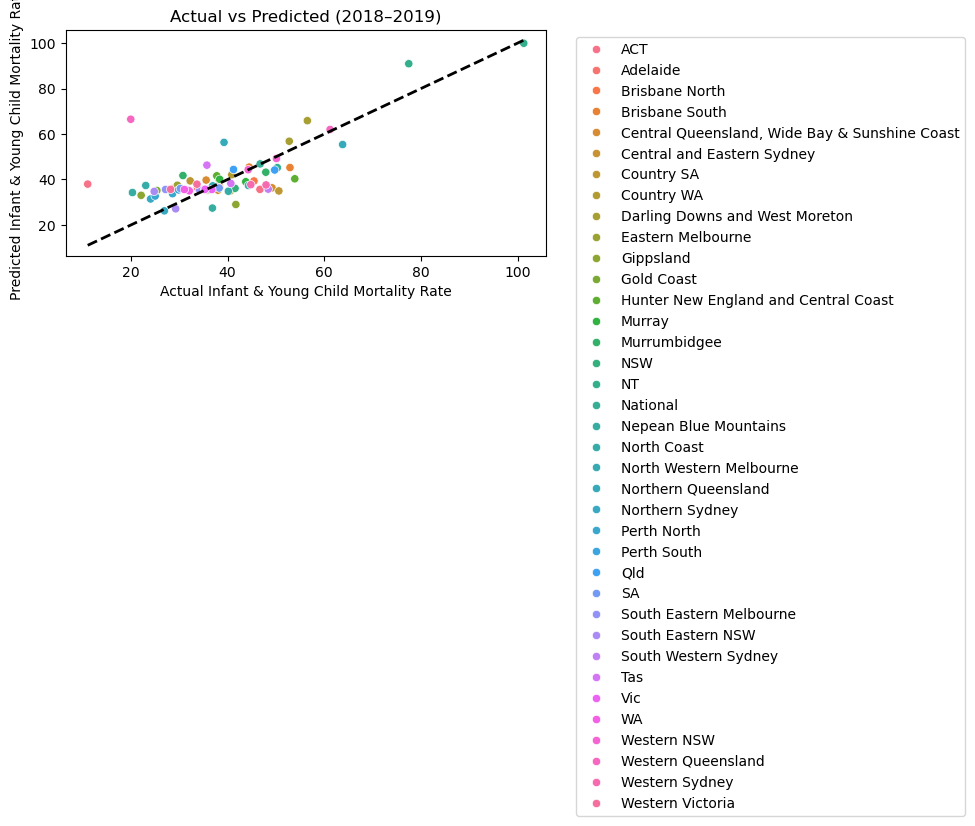

In [12]:
results = pd.DataFrame({
    "State": y_test.index.get_level_values(0),
    "Year": y_test.index.get_level_values(1),
    "Actual": y_test.values,
    "Predicted": pred_rf
})

plt.figure(figsize=(10,6))
sns.scatterplot(data=results, x="Actual", y="Predicted", hue="State")
plt.plot([results["Actual"].min(), results["Actual"].max()],
         [results["Actual"].min(), results["Actual"].max()],
         "k--", lw=2)
plt.title("Actual vs Predicted (2018–2019)")
plt.xlabel("Actual Infant & Young Child Mortality Rate")
plt.ylabel("Predicted Infant & Young Child Mortality Rate")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


This scatterplot compares the actual versus predicted infant and young child mortality rates for the test years (2018–2019), allowing us to visually assess the model’s accuracy. The majority of the points cluster closely around the 45-degree dashed line, indicating that the Random Forest model generally predicts values in line with observed outcomes. However, some states deviate further from the line, showing that the model underestimates or overestimates mortality rates in certain regions. Despite these outliers, the overall alignment suggests that the model captures key patterns well, though there is still room for refinement to improve accuracy at the state level.

## Forecasting Future Infant and Young Child Mortality Rates
In the final step, the trained Random Forest model is applied to the most recent year of available data in order to forecast mortality rates for the following year. This involves taking the lagged and current features from the latest year and using them as input to generate predictions for each state. The results are saved into a forecast table that includes the state, the base year, the forecasted year, and the predicted mortality rate. This step is valuable because it translates the modeling exercise into actionable forward-looking insights, helping identify which regions might face higher risks in the near future and where preventive interventions could be prioritized.

In [13]:
latest_year = wide_lag.index.get_level_values("Year").max()
last_rows   = wide_lag.xs(latest_year, level="Year", drop_level=False)
last_feats  = last_rows[FEATURE_COLS].copy()
next_pred   = best_rf.predict(last_feats)

forecast = last_rows.reset_index()[["State", "Year"]].copy()
forecast["Forecast_Year"] = forecast["Year"] + 1
forecast[f"Predicted_{TARGET}"] = next_pred
forecast.to_csv(OUT_DIR / "rf_forecast_next_year.csv", index=False)
print("\nSaved forecast to:", OUT_DIR.resolve())
print(forecast.head())



Saved forecast to: C:\Users\ANJANA MANOJ\Desktop\Capstone A\outputs\models
Name                                          State    Year  Forecast_Year  \
0                                               ACT  2019.0         2020.0   
1                                          Adelaide  2019.0         2020.0   
2                                    Brisbane North  2019.0         2020.0   
3                                    Brisbane South  2019.0         2020.0   
4     Central Queensland‚ Wide Bay & Sunshine Coast  2019.0         2020.0   

Name  Predicted_Infant and young child mortality rate  
0                                           37.969726  
1                                           36.059227  
2                                           39.337128  
3                                           45.246890  
4                                           36.321258  


The forecast results provide an estimate of infant and young child mortality rates for the year 2020 across different states and regions in Australia. The predictions show variation by location, with regions such as Brisbane South and ACT recording higher projected mortality rates (around 45 and 38 respectively), while others such as Adelaide and Central Queensland, Wide Bay & Sunshine Coast are predicted to remain slightly lower, in the mid-30s. These differences highlight regional disparities in health outcomes, possibly reflecting underlying differences in healthcare access, socioeconomic conditions, or population demographics. Importantly, while the predicted values are not extreme, they indicate that some states may continue to face higher risks if interventions are not prioritized. This forward-looking perspective makes the forecast a useful tool for policymakers, as it helps target resources and preventive measures in states with consistently higher predicted mortality rates.